In [135]:
pip install pydub ffmpeg-python requests librosa 

Note: you may need to restart the kernel to use updated packages.


In [136]:
import re
import pandas as pd
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split

## Use radio-browser.info API to obtain a list of public AM/FM stations that stream online, by country

In [24]:
import requests

def get_radio_stations(country="India", num=10):
    """
    Fetches a list of public AM/FM radio stations that stream online.
    """
    url = f"https://de1.api.radio-browser.info/json/stations/bycountry/{country}"
    response = requests.get(url)
    response.raise_for_status()  
    stations = response.json()
    
    station_list = [{"name": s["name"], "url": s["url_resolved"], "country": country} for s in stations if s["url_resolved"]]
    
    return station_list[:num]  



## Function to record audio

In [73]:
import subprocess
import threading
from datetime import datetime
from pydub import AudioSegment

def record_radio(stream_url, station_name, output_folder, duration=60, format="mp3"):
    """
    Records an online radio stream for a given duration.

    Parameters:
    - stream_url (str): URL of the radio stream.
    - station_name (str): Name of the radio station.
    - duration (int): Recording duration in seconds (default: 60s).
    - format (str): Output audio format (default: "mp3").

    Returns:
    - file_path (str): Path of the saved audio file.
    """
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    station_clean = station_name.replace(" ", "_").replace("/", "_")
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{station_clean}_{timestamp}.{format}"
    file_path = os.path.join(output_folder, filename)

    command = [
        "ffmpeg", "-i", stream_url, "-to", str(duration),
        "-acodec", "libmp3lame", "-y", file_path
    ]

    print(f"Recording {station_name} for {duration}s...")

    try:
        process = subprocess.Popen(command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        timer = threading.Timer(duration, process.terminate)
        timer.start()
        process.wait()
        timer.cancel()

        print(f"Recorded: {file_path}")
        return file_path
    except subprocess.CalledProcessError as e:
        print(f"Failed to record {station_name}: {e}")
        return None


In [74]:
def create_radio_files(radio_stations, country, output_folder, duration, max_audio_files):
    """
    Records a limited number of radio stations and stores metadata.

    Parameters:
    - radio_stations (list): List of dictionaries with 'name' and 'url'.
    - country (str): Country name.
    - output_folder (str): Path to save recordings.
    - duration (int): Recording duration in seconds.
    - max_audio_files (int): Maximum number of recordings allowed.

    Returns:
    - int: The actual number of successfully recorded files.
    """
    metadata_list = []
    print(f"🎙️ Processing {len(radio_stations)} stations from {country}...")

    num_files_to_record = min(len(radio_stations), max_audio_files)
    successful_records = 0  

    for i in range(num_files_to_record):
        station = radio_stations[i]
        station_name = station["name"]
        stream_url = station["url"]

        print(f"🎧 Recording {station_name} ({i+1}/{num_files_to_record})...")
        
        file_path = record_radio(stream_url, station_name, output_folder, duration=duration)

        if file_path:  
            successful_records += 1
        else:
            print(f"Failed to record {station_name}")

    print(f"Done! Successfully recorded {successful_records}/{num_files_to_record} stations.")
    
    return successful_records  


In [75]:
def get_radio_stations_list(countries, number_of_stations):
    """
    Returns a list of radio stations for a list of countries
    Parameters:
    - countries (list): List of countries.
    - number_of_stations(list): Number of stations to be recorded for each country.

    Returns:
    - dictionary: A dictionary containing name, url and country for each station
    """
    radio_stations = {}
    for i in range(0, len(countries)):
        radio_stations[countries[i]] = get_radio_stations(countries[i], number_of_stations[i])
        
    return radio_stations

In [76]:
countries = ["India", "United States of America", "Italy"]
number_of_stations = [12, 12, 12]
radio_stations = get_radio_stations_list(countries, number_of_stations)

In [77]:
radio_stations

{'India': [{'name': '2B! Radio Sangam Devi Maa',
   'url': 'http://ibadat.out.airtime.pro:8000/ibadat_a',
   'country': 'India'},
  {'name': '2B! Radio Sangam Ganesha',
   'url': 'http://radio2bindia.out.airtime.pro:8000/radio2bindia_a',
   'country': 'India'},
  {'name': '2B! Radio Sangam Guruvar',
   'url': 'http://iskon2b.out.airtime.pro:8000/iskon2b_a',
   'country': 'India'},
  {'name': '2B! Radio Sangam Krishna',
   'url': 'http://millenniumhits.out.airtime.pro:8000/millenniumhits_a',
   'country': 'India'},
  {'name': '2B! Radio Sangam Meditation',
   'url': 'http://djbeat.out.airtime.pro:8000/djbeat_a',
   'country': 'India'},
  {'name': '2B! Radio Sangam Shiva',
   'url': 'http://hot.out.airtime.pro:8000/hot_a',
   'country': 'India'},
  {'name': '2B! Radio Sangam Shri Ram',
   'url': 'http://dard.out.airtime.pro:8000/dard_a',
   'country': 'India'},
  {'name': '4 lobos bollywood radio',
   'url': 'https://puma.streemlion.com:4130/stream',
   'country': 'India'},
  {'name': '4

In [79]:
radio_stations['India'][0]

{'name': '2B! Radio Sangam Devi Maa',
 'url': 'http://ibadat.out.airtime.pro:8000/ibadat_a',
 'country': 'India'}

In [1]:
import os

def record_files(output_folder, radio_stations, durations, audio_files=10):
    """
    Function: record_files

    Description:
        The `record_files` function records audio from multiple online radio stations and saves the files in a specified output folder. 
        It ensures that each radio station generates a required number of audio files while handling interruptions and retries.

    Parameters:
        - output_folder (str): The path to the folder where recorded audio files will be stored.
        - radio_stations (dict): A dictionary where keys are station names and values are their respective streaming URLs.
        - durations (list): A list of durations (in seconds) corresponding to each station, specifying the recording length per attempt.
        - audio_files (int, optional): The total number of audio files to generate per station. Default is 10.

    Returns:
        None (The function saves recorded audio files directly in the `output_folder`).

    
    """
    os.makedirs(output_folder, exist_ok=True)
    i = 0
    for key, value in radio_stations.items():
        sr = create_radio_files(value, key, output_folder, durations[i], audio_files)
        i = 0
        while sr < audio_files:
            if i > 4:
                break
            diff = audio_files - sr
            sr = sr + create_radio_files(value, key, output_folder, durations[i], diff)
            i = i + 1


In [97]:
durations = [45, 45, 45]
record_files(f"/Users/user/Downloads/radio_recordings", radio_stations, durations, 10)

🎙️ Processing 12 stations from India...
🎧 Recording 2B! Radio Sangam Devi Maa (1/10)...
Recording 2B! Radio Sangam Devi Maa for 45s...
Recorded: /Users/user/Downloads/radio_recordings/2B!_Radio_Sangam_Devi_Maa_20250306_195130.mp3
🎧 Recording 2B! Radio Sangam Ganesha (2/10)...
Recording 2B! Radio Sangam Ganesha for 45s...
Recorded: /Users/user/Downloads/radio_recordings/2B!_Radio_Sangam_Ganesha_20250306_195208.mp3
🎧 Recording 2B! Radio Sangam Guruvar (3/10)...
Recording 2B! Radio Sangam Guruvar for 45s...
Recorded: /Users/user/Downloads/radio_recordings/2B!_Radio_Sangam_Guruvar_20250306_195243.mp3
🎧 Recording 2B! Radio Sangam Krishna (4/10)...
Recording 2B! Radio Sangam Krishna for 45s...
Recorded: /Users/user/Downloads/radio_recordings/2B!_Radio_Sangam_Krishna_20250306_195320.mp3
🎧 Recording 2B! Radio Sangam Meditation (5/10)...
Recording 2B! Radio Sangam Meditation for 45s...
Recorded: /Users/user/Downloads/radio_recordings/2B!_Radio_Sangam_Meditation_20250306_195356.mp3
🎧 Recording 2

In [101]:
all_stations = []
for key, value in radio_stations.items():
    all_stations.extend(value)
    
station_metadata = {
    station["name"].replace(" ", "_"): {"url": station["url"], "country": station["country"]}
    for station in all_stations
}

In [102]:
station_metadata

{'2B!_Radio_Sangam_Devi_Maa': {'url': 'http://ibadat.out.airtime.pro:8000/ibadat_a',
  'country': 'India'},
 '2B!_Radio_Sangam_Ganesha': {'url': 'http://radio2bindia.out.airtime.pro:8000/radio2bindia_a',
  'country': 'India'},
 '2B!_Radio_Sangam_Guruvar': {'url': 'http://iskon2b.out.airtime.pro:8000/iskon2b_a',
  'country': 'India'},
 '2B!_Radio_Sangam_Krishna': {'url': 'http://millenniumhits.out.airtime.pro:8000/millenniumhits_a',
  'country': 'India'},
 '2B!_Radio_Sangam_Meditation': {'url': 'http://djbeat.out.airtime.pro:8000/djbeat_a',
  'country': 'India'},
 '2B!_Radio_Sangam_Shiva': {'url': 'http://hot.out.airtime.pro:8000/hot_a',
  'country': 'India'},
 '2B!_Radio_Sangam_Shri_Ram': {'url': 'http://dard.out.airtime.pro:8000/dard_a',
  'country': 'India'},
 '4_lobos_bollywood_radio': {'url': 'https://puma.streemlion.com:4130/stream',
  'country': 'India'},
 '4lobos_bollywood_radio': {'url': 'http://puma.streemlion.com:4130/stream',
  'country': 'India'},
 '60sforever': {'url': 'ht

In [103]:
def record_metadata(recordings_folder):
    """
    Function: record_metadata

    Description:
        Extracts metadata from recorded audio files stored in a given folder. It retrieves station names,
        timestamps, durations, and associated station information, then saves this data into a CSV file.

    Parameters:
        - recordings_folder (str): Path to the folder containing recorded audio files.

    Returns:
        None (The metadata is saved directly as a CSV file).

    """
    metadata_list = []

    for file in os.listdir(recordings_folder):
        if file.endswith(".mp3") or file.endswith(".wav"):
            file_path = os.path.join(recordings_folder, file)

            file_name = file.rsplit(".", 1)[0]

            file_parts = file_name.rsplit("_", 2)  
            if len(file_parts) < 3:
                print(f"Filename format unexpected: {file}")
                continue

            station_name = file_parts[0]  

            print(f"Extracted Station Name: {station_name}")
            print(f"Raw Timestamp String: {file_parts[1]}_{file_parts[2]}")

            try:
                timestamp_str = f"{file_parts[1]}_{file_parts[2]}" 
                timestamp = datetime.strptime(timestamp_str, "%Y%m%d_%H%M%S")  
            except (ValueError, IndexError):
                timestamp = None  

            print(f"Parsed Timestamp: {timestamp}")

            audio = AudioSegment.from_file(file_path)
            duration = round(len(audio) / 1000, 2)  

            station_info = station_metadata.get(station_name, {"url": "Unknown", "country": "Unknown"})

            if station_info["url"] == "Unknown":
                print(f"No match found for: {station_name} (Filename: {file})")

            metadata_list.append({
                "Station Name": station_name,
                "Country": station_info["country"],
                "Stream URL": station_info["url"],
                "Timestamp": timestamp.strftime("%Y-%m-%d %H:%M:%S") if timestamp else "Unknown",
                "Duration (s)": duration,
                "File Path": file_path
            })

    df_metadata = pd.DataFrame(metadata_list)

    csv_file = os.path.join(recordings_folder, "radio_metadata.csv")
    df_metadata.to_csv(csv_file, index=False)

    print(f"Metadata saved to {csv_file}")


In [104]:
recordings_folder = "/Users/user/Downloads/radio_recordings"
record_metadata(recordings_folder)

Extracted Station Name: _Rai_Radio_1_Sport
Raw Timestamp String: 20250306_200646
Parsed Timestamp: 2025-03-06 20:06:46
Extracted Station Name: 4_lobos_bollywood_radio
Raw Timestamp String: 20250306_195541
Parsed Timestamp: 2025-03-06 19:55:41
Extracted Station Name: _Houston_Sports_Radio_610_KILT
Raw Timestamp String: 20250306_200117
Parsed Timestamp: 2025-03-06 20:01:17
Extracted Station Name: _Radio_Energy_Classic_(Italy)
Raw Timestamp String: 20250306_200750
Parsed Timestamp: 2025-03-06 20:07:50
Extracted Station Name: 2B!_Radio_Sangam_Shri_Ram
Raw Timestamp String: 20250306_195506
Parsed Timestamp: 2025-03-06 19:55:06
Extracted Station Name: _Radio_Rouge_Italy
Raw Timestamp String: 20250306_200605
Parsed Timestamp: 2025-03-06 20:06:05
Extracted Station Name: 60sforever
Raw Timestamp String: 20250306_195658
Parsed Timestamp: 2025-03-06 19:56:58
Extracted Station Name: 2B!_Radio_Sangam_Meditation
Raw Timestamp String: 20250306_195356
Parsed Timestamp: 2025-03-06 19:53:56
Extracted St

### Training a classifier to predict which country the audio file belongs to

In [105]:
metadata = pd.read_csv(f'{recordings_folder}/radio_metadata.csv')

In [106]:
metadata.head(5)

,Station Name,Country,Stream URL,Timestamp,Duration (s),File Path
0,_Rai_Radio_1_Sport,Italy,http://icecdn-19d24861e90342cc8decb03c24c8a419...,2025-03-06 20:06:46,45.00,/Users/user/Downloads/radio_recordings/_Rai_Ra...
1,4_lobos_bollywood_radio,India,https://puma.streemlion.com:4130/stream,2025-03-06 19:55:41,45.00,/Users/user/Downloads/radio_recordings/4_lobos...
2,_Houston_Sports_Radio_610_KILT,United States of America,https://prod-3-238-150-237.amperwave.net/audac...,2025-03-06 20:01:17,30.05,/Users/user/Downloads/radio_recordings/_Housto...
3,_Radio_Energy_Classic_(Italy),Italy,https://gmusto3.radioca.st/stream,2025-03-06 20:07:50,45.00,/Users/user/Downloads/radio_recordings/_Radio_...
4,2B!_Radio_Sangam_Shri_Ram,India,http://dard.out.airtime.pro:8000/dard_a,2025-03-06 19:55:06,45.00,/Users/user/Downloads/radio_recordings/2B!_Rad...


In [107]:
import os
import pandas as pd
from pydub import AudioSegment

# Path to radio recordings
recordings_folder = "/Users/user/Downloads/radio_recordings"
output_folder = "/Users/user/Downloads/radio_clips"

os.makedirs(output_folder, exist_ok=True)

# List all MP3 files
audio_files = [f for f in os.listdir(recordings_folder) if f.endswith(".mp3")]

print(f"Found {len(audio_files)} audio files!")


Found 27 audio files!


In [108]:
clip_metadata = []

for file in audio_files:
    file_path = os.path.join(recordings_folder, file)

    station_name = file.rsplit("_", 2)[0]  # Extracts station name before timestamp

    # Lookup country from metadata
    station_info = station_metadata.get(station_name, {"country": "Unknown"})
    country_label = station_info["country"]

    # Load audio file
    audio = AudioSegment.from_file(file_path)
    clip_length = 5000  # 5 seconds (5000 ms)
    
    # Generate clips(5 seconds each)
    num_clips = len(audio) // clip_length
    for i in range(num_clips):
        clip = audio[i * clip_length : (i + 1) * clip_length]
        
        # Save clip
        clip_filename = f"{station_name}_clip_{i+1}_{country_label}.mp3"
        clip_path = os.path.join(output_folder, clip_filename)
        clip.export(clip_path, format="mp3")
        
        # Store metadata
        clip_metadata.append({
            "Clip Name": clip_filename,
            "Station Name": station_name,
            "Country": country_label,
            "Start Time (s)": i * 5,
            "End Time (s)": (i + 1) * 5,
            "File Path": clip_path
        })

    print(f"Processed {file} → {num_clips} clips")

df_clips = pd.DataFrame(clip_metadata)
df_clips.to_csv(os.path.join(output_folder, "clip_metadata.csv"), index=False)

print(f"Saved {len(df_clips)} clips & metadata!")


Processed _Rai_Radio_1_Sport_20250306_200646.mp3 → 9 clips
Processed 4_lobos_bollywood_radio_20250306_195541.mp3 → 9 clips
Processed _Houston_Sports_Radio_610_KILT_20250306_200117.mp3 → 6 clips
Processed _Radio_Energy_Classic_(Italy)_20250306_200750.mp3 → 9 clips
Processed 2B!_Radio_Sangam_Shri_Ram_20250306_195506.mp3 → 9 clips
Processed _Radio_Rouge_Italy_20250306_200605.mp3 → 9 clips
Processed 60sforever_20250306_195658.mp3 → 9 clips
Processed 2B!_Radio_Sangam_Meditation_20250306_195356.mp3 → 9 clips
Processed 2B!_Radio_Sangam_Shiva_20250306_195431.mp3 → 9 clips
Processed _ESPN_1320_-_Sacramento_20250306_195959.mp3 → 10 clips
Processed 2B!_Radio_Sangam_Krishna_20250306_195320.mp3 → 9 clips
Processed 2B!_Radio_Sangam_Ganesha_20250306_195208.mp3 → 9 clips
Processed 	Radio_Margherita__20250306_200316.mp3 → 9 clips
Processed 	Radio_Bruno_Pentasport_Fiorentina_20250306_200200.mp3 → 9 clips
Processed 2B!_Radio_Sangam_Devi_Maa_20250306_195130.mp3 → 9 clips
Processed 2B!_Radio_Sangam_Guruvar

In [112]:
clips_folder = "/Users/user/Downloads/radio_clips"
metadata_file = os.path.join(clips_folder, "clip_metadata.csv")

df = pd.read_csv(metadata_file)
df["File Path"] = df["File Path"].str.strip()  

In [114]:
df

,Clip Name,Station Name,Country,Start Time (s),End Time (s),File Path
0,_Rai_Radio_1_Sport_clip_1_Italy.mp3,_Rai_Radio_1_Sport,Italy,0,5,/Users/user/Downloads/radio_clips/_Rai_Radio_1...
1,_Rai_Radio_1_Sport_clip_2_Italy.mp3,_Rai_Radio_1_Sport,Italy,5,10,/Users/user/Downloads/radio_clips/_Rai_Radio_1...
2,_Rai_Radio_1_Sport_clip_3_Italy.mp3,_Rai_Radio_1_Sport,Italy,10,15,/Users/user/Downloads/radio_clips/_Rai_Radio_1...
3,_Rai_Radio_1_Sport_clip_4_Italy.mp3,_Rai_Radio_1_Sport,Italy,15,20,/Users/user/Downloads/radio_clips/_Rai_Radio_1...
4,_Rai_Radio_1_Sport_clip_5_Italy.mp3,_Rai_Radio_1_Sport,Italy,20,25,/Users/user/Downloads/radio_clips/_Rai_Radio_1...
...,...,...,...,...,...,...
236,4lobos_bollywood_radio_clip_5_India.mp3,4lobos_bollywood_radio,India,20,25,/Users/user/Downloads/radio_clips/4lobos_bolly...
237,4lobos_bollywood_radio_clip_6_India.mp3,4lobos_bollywood_radio,India,25,30,/Users/user/Downloads/radio_clips/4lobos_bolly...
238,4lobos_bollywood_radio_clip_7_India.mp3,4lobos_bollywood_radio,India,30,35,/Users/user/Downloads/radio_clips/4lobos_bolly...
239,4lobos_bollywood_radio_clip_8_India.mp3,4lobos_bollywood_radio,India,35,40,/Users/user/Downloads/radio_clips/4lobos_bolly...


## Extracting MFCC features for each clip

In [120]:
def extract_features(file_path, max_length=5, mfcc_coefs=13):
    y, sr = librosa.load(file_path, sr=22050)  # Load audio
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=mfcc_coefs)  # Extract 40 MFCCs
    mfcc = np.mean(mfcc, axis=1)  # Take mean across time axis
    return mfcc

In [121]:
X, y = [], []
for _, row in df.iterrows():
    file_path = row["File Path"]
    label = row["Country"]

    if os.path.exists(file_path):  # Check if file exists
        features = extract_features(file_path)
        X.append(features)
        y.append(label)

In [122]:
X[0].shape

(13,)

In [123]:
X[0]

array([-288.7693   ,  135.07867  ,  -38.09517  ,   33.315918 ,
         15.817051 ,   -7.4661813,    7.43677  ,   16.10818  ,
         -4.306575 ,    5.169187 ,    4.2154927,    2.4711614,
          1.692009 ], dtype=float32)

In [125]:
y[0]

'Italy'

In [126]:
X = np.array(X)
y = np.array(y)


In [127]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y = encoder.fit_transform(y)  


In [144]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)



In [146]:
print(f"Data Ready: {X_train.shape[0]} train samples, {X_test.shape[0]} test samples")


Data Ready: 192 train samples, 49 test samples


## Training an audio classifier to predict country the clip belongs to

In [147]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [148]:
class AudioClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AudioClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

In [149]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [150]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [151]:
num_classes = len(set(y_train))
input_size = X_train.shape[1]

model = AudioClassifier(input_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 30
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)
    
    for inputs, labels in progress_bar:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=running_loss / len(train_loader))

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

print("Model Training Complete!")


Epoch 1/30, Loss: 4.3245


Epoch 2/30, Loss: 2.2602


Epoch 3/30, Loss: 1.6190


Epoch 4/30, Loss: 1.5045


Epoch 5/30, Loss: 1.3241


Epoch 6/30, Loss: 1.0613


Epoch 7/30, Loss: 0.9798


Epoch 8/30, Loss: 1.0574


Epoch 9/30, Loss: 0.8675


Epoch 10/30, Loss: 0.8298


Epoch 11/30, Loss: 0.7213


Epoch 12/30, Loss: 0.8174


Epoch 13/30, Loss: 0.6960


Epoch 14/30, Loss: 0.7576


Epoch 15/30, Loss: 0.7570


Epoch 16/30, Loss: 0.6805


Epoch 17/30, Loss: 0.7365


Epoch 18/30, Loss: 0.6631


Epoch 19/30, Loss: 0.6440


Epoch 20/30, Loss: 0.6108


Epoch 21/30, Loss: 0.6645


Epoch 22/30, Loss: 0.6961


Epoch 23/30, Loss: 0.6395


Epoch 24/30, Loss: 0.6261


Epoch 25/30, Loss: 0.5612


Epoch 26/30, Loss: 0.5705


Epoch 27/30, Loss: 0.6211


Epoch 28/30, Loss: 0.5490


Epoch 29/30, Loss: 0.5000


Epoch 30/30, Loss: 0.5965
Model Training Complete!


🎯 Test Accuracy: 0.8980
Classification Report:
                          precision    recall  f1-score   support

                   India       0.89      0.94      0.92        18
                   Italy       0.83      0.88      0.86        17
United States of America       1.00      0.86      0.92        14

                accuracy                           0.90        49
               macro avg       0.91      0.89      0.90        49
            weighted avg       0.90      0.90      0.90        49



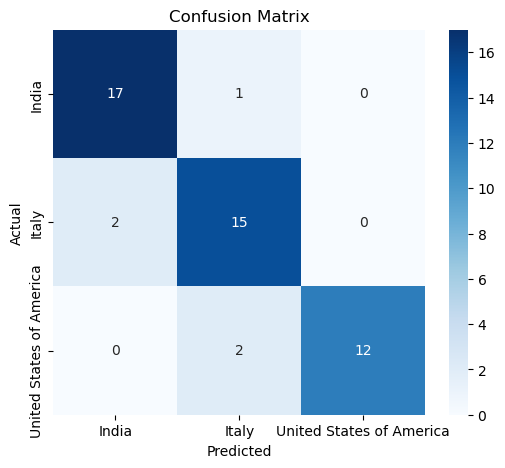

In [153]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model.eval()

all_preds = []
all_labels = []

with torch.no_grad():  # No gradients needed
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)  # Get predicted class

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_preds)
print(f"🎯 Test Accuracy: {accuracy:.4f}")

class_names = encoder.inverse_transform(np.unique(y))  
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
